# Deep Optimal Stopping with TensorFlow

This notebook implements Deep Optimal Stopping for:
- Bermudan Max-Call Option
- Callable Multi-Barrier Reverse Convertible
- Fractional Brownian Motion

Includes grid search, confidence intervals, dual upper bounds, and reward plots.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import scipy.stats as st
import matplotlib.pyplot as plt
from scipy.linalg import cholesky
from IPython.display import display
from functools import partial
import time


## Setup Optimal Stopping


In [2]:
# Set random seed for reproducibility
np.random.seed(2)
tf.random.set_seed(2)

# Global settings from the paper
KL = 4096000
KU = 1024
J_Def = 163
EPOCH_BASE = 30
# Paper baseline

In [3]:
class StoppingPolicy(tf.keras.Model):
    def __init__(self, d):
        super().__init__()
        hidden_units = d + 40
        self.net = tf.keras.Sequential([
            # first hidden layer: width = d + 40
            tf.keras.layers.Dense(hidden_units, activation='relu', kernel_initializer='glorot_uniform'),
            tf.keras.layers.BatchNormalization(),

            # second hidden layer: same width
            tf.keras.layers.Dense(hidden_units, activation='relu', kernel_initializer='glorot_uniform'),
            tf.keras.layers.BatchNormalization(),

            # output layer: single sigmoid
            tf.keras.layers.Dense(1,activation='sigmoid',kernel_initializer='glorot_uniform')
        ])

    def call(self, x):
        # x shape: (batch_size, d)
        return self.net(x)


In [4]:
def stopping_loss(probs, g_now, g_future):
    return -tf.reduce_mean(probs * g_now + (1 - probs) * g_future)

In [5]:
def train_stopping_policies(X_paths, g_fn, N, d,
                            lr=1e-3, epochs=None,
                            batch=8192, patience=5, tol=1e-4):
    if epochs is None:
        epochs = EPOCH_BASE

    M = X_paths.shape[1]
    tau_mat = np.full((N+1, M), N, dtype=np.int32)
    f_mat   = np.zeros((N+1, M), dtype=np.float32)
    f_mat[N] = 1.0

    policies   = []
    prev_loss  = np.inf
    bad_epochs = 0

    for n in reversed(range(N)):
        model = StoppingPolicy(d)
        opt   = tf.keras.optimizers.Adam(lr)

        Xn_tf  = tf.convert_to_tensor(X_paths[n], tf.float32)
        g_now  = tf.convert_to_tensor(g_fn(n,        X_paths), tf.float32)
        g_next = tf.convert_to_tensor(g_fn(tau_mat[n+1], X_paths), tf.float32)

        dataset = (tf.data.Dataset
              .from_tensor_slices((Xn_tf, g_now, g_next))
              .shuffle(M, seed=2)
              .batch(batch))

        for epoch in range(epochs):
            epoch_loss = 0.0
            for xb, g_b, g_next_b in dataset:
                with tf.GradientTape() as tape:
                    p    = model(xb)
                    loss = -tf.reduce_mean(p * g_b + (1 - p) * g_next_b)
                grads = tape.gradient(loss, model.trainable_variables)
                opt.apply_gradients(zip(grads, model.trainable_variables))
                epoch_loss += loss.numpy()

            if abs(prev_loss - epoch_loss) < tol:
                bad_epochs += 1
                if bad_epochs >= patience:
                    print(f"  n={n}, converged at epoch {epoch+1}")
                    break
            else:
                bad_epochs = 0
            prev_loss = epoch_loss

        probs  = np.squeeze(model(Xn_tf).numpy())
        decide = (probs > 0.5).astype(np.int32)

        f_mat[n]   = decide
        tau_mat[n] = decide
        policies.append(model)

# policies is in reverse time order; reverse it so policies[0] corresponds to t=0:
    stop_networks = list(reversed(policies))
    
    return tau_mat, f_mat, stop_networks   # policies[0] is time-0 net, etc.


In [6]:
def evaluate_policy(X_paths, tau_mat, g_fn):
    global KL
    
    M = X_paths.shape[1]
    tau_0 = tau_mat[0, :].astype(int)
    rewards = g_fn(tau_0, X_paths)
    mean_val = np.mean(rewards)
    std_err = np.std(rewards) / np.sqrt(M)
    z = scipy.stats.norm.ppf(0.975)
    return mean_val, mean_val - z * std_err, mean_val + z * std_err

In [7]:
def plot_confidence_interval(values, title):
    values = np.asarray(values, dtype=np.float32)
    mean = values.mean()
    se   = values.std(ddof=1) / np.sqrt(values.size)
    ci   = st.norm.ppf(0.975) * se

    plt.figure(figsize=(8, 4))
    plt.title(title)
    plt.axhline(mean, color='tab:blue',
                label=f"Mean = {mean:.4f}")
    plt.fill_between(range(values.size),
                     mean - ci, mean + ci,
                     color='tab:blue', alpha=0.20,
                     label="95 % CI")
    plt.plot(values, '.', alpha=0.4, color='gray')
    plt.legend(); plt.grid(); plt.show()


## Examples

### Code for Duality

In [8]:
def bs_conditional_paths(n, x_n, J, *, N, dt, r, sigma, delta):
    """
    Vectorised conditional simulation used in the dual upper bound.

    Parameters
    ----------
    n      : branch index (0 … N-1)
    x_n    : state at time index n, shape (d,)
    J      : number of continuations
    N, dt  : total grid length and time-step  (exact, pass in from model)
    r, sigma, delta : Black–Scholes parameters

    Returns
    -------
    cube : ndarray, shape (N-n+1, J, d)
           first slice equals x_n
    """
    d     = x_n.size
    steps = N - n                      # *** exact integer ***
    if steps == 0:                     # already at maturity
        return np.tile(x_n[None, None, :], (1, J, 1))

    Z   = np.random.randn(steps, J, d).astype(np.float32)
    mu  = (r - delta - 0.5 * sigma**2) * dt
    vol = sigma * np.sqrt(dt)
    log_inc = mu + vol * Z             # (steps,J,d)
    log_S   = np.cumsum(log_inc, axis=0)
    S       = x_n[None, None, :] * np.exp(log_S)

    first   = np.tile(x_n[None, None, :], (1, J, 1))   # (1,J,d)
    return np.concatenate([first, S], axis=0)          # (steps+1,J,d)


In [9]:
def estimate_upper_bound_dual(
        X_paths,                      # (N+1, KU, d)
        tau_mat,                      # (N+1, KU)   0/1 indicator
        g_fn,     # payoff g(n, X_slice)
        stop_networks, 
        simulate_conditional_fn=None,      # callback (n, X_n, J) -> (N+1−n,J,d)
        J=J_Def,
        alpha=0.05):
    """
    Rogers–Haugh–Kogan dual upper bound with the paper’s
    K × J inner simulation of continuation values.

    simulate_conditional_fn
        must return *J* conditionally independent continuations of
        the underlying *starting from the specific state X_n*.

        Signature:
            simulate_conditional_fn(n: int,
                                    X_n: ndarray(d,),
                                    J: int) -> ndarray(N+1−n, J, d)
    """
    N_plus_1, KU, d = X_paths.shape
    N = N_plus_1 - 1

    # 1) g(n, X_n,k)  – pre-compute for the primary cube
    g_vals = np.empty((N_plus_1, KU), dtype=np.float32)
    for n in range(N_plus_1):
        g_vals[n] = g_fn(n, X_paths[n])

    # 2) τ_k  and realised payoff at τ_k
    stop_idx  = tau_mat.argmax(axis=0)           # (KU,)
    #g_at_tau  = g_vals[stop_idx, np.arange(KU)] remove as not used

    # 3) continuation values C_n,k  via inner Monte Carlo
    C = np.empty_like(g_vals)
    C[N] = g_vals[N]                                   # C_N never used

    for n in range(N - 1, -1, -1):                     # backward induction
        C[n] = C[n + 1]                                # initialise with row n+1
        alive = stop_idx > n                           # paths still running
        if not alive.any():
            continue

        alive_idx = np.where(alive)[0]                 # indices of live primaries
        K_alive   = len(alive_idx)

        # --- (a) simulate all continuations in one big tensor -------------
        # shape (steps+1 , K_alive*J , d)
        steps = N - n
        cont_big = np.empty((steps + 1, K_alive * J, d), np.float32)

        for pos, k in enumerate(alive_idx):
            cont_big[:, pos * J:(pos + 1) * J] = simulate_conditional_fn(
                n, X_paths[n, k], J)

        # --- (b) decide when to stop each continuation -------------------
        # initialise: exercise at maturity
        stop_time = np.zeros(K_alive * J, np.int32) + N
        alive_mask = np.ones(K_alive * J, bool)

        for t in range(n + 1, N):
            if not alive_mask.any():
                break
            Xi   = cont_big[t - n, alive_mask]               # (J_alive , d)
            probs = stop_networks[t](Xi).numpy().ravel()
            decide = probs > 0.5
            idx_global = np.where(alive_mask)[0][decide]
            stop_time[idx_global] = t
            alive_mask[idx_global] = False                   # frozen path

        # --- (c) payoff of each continuation -----------------------------
        # gather slices in one vectorised call
        payoff = np.empty(K_alive * J, np.float32)
        for t in range(n + 1, N + 1):                       # include N
            idx = np.where(stop_time == t)[0]
            if idx.size:
                payoff[idx] = g_fn(
                    t,
                    cont_big[t - n, idx].reshape((idx.size, d)))

        # reshape back: (K_alive , J)
        payoff = payoff.reshape(K_alive, J)
        C[n, alive_idx] = payoff.mean(axis=1)               # MC average

    # 4) martingale with I_{n-1}
    f_theta = tau_mat.astype(np.float32)
    I = np.ones_like(f_theta)
    for n in range(1, N_plus_1):
        I[n] = I[n-1]*(1.0 - f_theta[n-1])

    dM = np.zeros_like(g_vals)
    for n in range(1, N_plus_1):
        dM[n] = I[n-1]*(f_theta[n]*g_vals[n] +
                        (1-f_theta[n])*C[n] - C[n-1])

    M_vals = dM.cumsum(axis=0)

    # 5) pathwise max and confidence interval
    U_path = (g_vals - M_vals).max(axis=0)
    U_hat  = U_path.mean()
    se     = U_path.std(ddof=1)/np.sqrt(KU)
    hw     = st.norm.ppf(1-alpha/2)*se
    return U_hat, U_hat-hw, U_hat+hw


### General Code for paper replication

In [10]:
def replicate_paper_result(name, g_fn, sim_func, d, N,
                           lr=1e-4, epochs=None,J=None, alpha=0.05):
    if epochs is None:
        epochs = EPOCH_BASE + d
        
    if J is None:
        J = J_Def 

    print(f"\n[REPLICATION PAPER] {name}")
    print(f"Training with lr={lr}, epochs={epochs} …")

    t0 = time.time()
    X_train = sim_func()
    tau_mat, f_mat, stop_networks = train_stopping_policies(
        X_train, g_fn, N, d, lr=lr, epochs=epochs)
    train_time = time.time() - t0

    print(f"Training complete in {train_time:.2f} seconds.")

    # lower‐bound exactly as before…
    X_eval  = sim_func()
    tau0    = tau_mat.argmax(axis=0)
    rewards = g_fn(tau0, X_eval)
    L_hat   = rewards.mean()
    se_L    = rewards.std(ddof=1) / np.sqrt(len(rewards))
    half_L  = st.norm.ppf(1 - alpha/2) * se_L
    L_CI    = (L_hat - half_L, L_hat + half_L)
    print(f"\n Estimated Lower Bound (L̂): {L_hat:.4f}")
    print(f"   95% CI: [{L_CI[0]:.4f}, {L_CI[1]:.4f}]")

       # only if g_fn is a bound method of a BS‐model
    model = getattr(g_fn, "__self__", None)
    if model is not None and hasattr(model, "sigma"):
        sim_bs = partial(bs_conditional_paths,
                         N     = model.N,
                         dt    = model.dt,
                         r     = model.r,
                         sigma = model.sigma,
                         delta = getattr(model, "delta", 0.0))
        U_hat, U_lo, U_hi = estimate_upper_bound_dual(
            X_train, tau_mat, g_fn,
            stop_networks=stop_networks,
            simulate_conditional_fn=sim_bs,
            J=J, alpha=alpha
        )
        print(f"\n Estimated Upper Bound (Û): {U_hat:.4f}")
        print(f"   95% CI: [{U_lo:.4f}, {U_hi:.4f}]")
    else:
        print("\n Dual upper bound skipped (no BS model detected).")
        U_hat, U_lo, U_hi = np.nan, np.nan, np.nan

    # --- MIDPOINT ----------------------------------------------------------
    midpoint = np.nan if np.isnan(U_hat) else 0.5*(L_hat + U_hat)
    if not np.isnan(midpoint):
        print(f"\n Point Estimate (Midpoint): {midpoint:.4f}")

    # --- PLOT ----------------------------------------------------------------
    plot_confidence_interval(rewards, f"Reward Distribution: {name}")

    return {
        "L_hat":          L_hat,
        "U_hat":          U_hat,
        "L_CI":           L_CI,
        "U_CI":           (U_lo, U_hi),
        "point_estimate": midpoint,
        "lr":             lr,
        "epochs":         epochs,
        "train_time_sec": round(train_time, 2)
    }


In [11]:
#  Hyperparameter Grid Search 

def grid_search_lr_epochs(X_paths, g_fn, N, d, lrs=[1e-3, 1e-4], epochs_list=None):
    if epochs_list is None:
        center = EPOCH_BASE + d
        epochs_list = [center - 200, center, center + 200]

    results = []
    best_val = -np.inf
    best_params = None

    for lr in lrs:
        for ep in epochs_list:
            print(f"Training with lr={lr}, epochs={ep}...")
            tau_mat = train_stopping_policies(X_paths, g_fn, N, d, lr=lr, epochs=ep)
            mean_val, *_ = evaluate_policy(X_paths, tau_mat, g_fn)

            results.append({
                'lr': lr,
                'epochs': ep,
                'mean_value': mean_val
            })

            if mean_val > best_val:
                best_val = mean_val
                best_params = (lr, ep)

    df_results = pd.DataFrame(results)
    return best_params, best_val, df_results

## Example 1: Bermudan Max-Call Option

In [12]:
class BermudanCall:
    def __init__(self, T, K, sigma, delta, S0, r, N, M, d):
        self.T, self.K, self.sigma, self.delta = T, K, sigma, delta
        self.S0, self.r   = S0, r
        self.N, self.M, self.d = N, M, d
        self.dt = T / N

    #  Monte-Carlo path simulator 
    def simulate(self):
        Z = np.random.normal(size=(self.N, self.M, self.d)).astype(np.float32)
        drift  = (self.r - self.delta - 0.5*self.sigma**2) * self.dt
        vol    = self.sigma * np.sqrt(self.dt)
        logS   = np.cumsum(drift + vol*Z, axis=0)
        S      = self.S0 * np.exp(logS)
        S0     = self.S0 * np.ones((1, self.M, self.d), np.float32)
        return np.concatenate([S0, S], axis=0)            # (N+1,M,d)

    #  payoff g(n,S)  (vectorised, robust) 
    def g(self, n, S):
        """
        Accepts
          • n scalar      & S slice  (M,d)
          • n scalar      & S cube   (N+1,M,d)
          • n vector(M,)  & S cube   (N+1,M,d)
        Returns vector (M,)
        """
        # --- choose the correct slice ------
        if S.ndim == 3:                                    # full cube
            if np.isscalar(n):
                S_n = S[int(n)]                            # (M,d)
            else:                                          # n vector
                idx = np.asarray(n, dtype=int)
                S_n = S[idx, np.arange(idx.size)]          # fancy indexing
        else:
            S_n = S                                        # already (M,d)

        payoff = np.maximum(S_n.max(axis=1) - self.K, 0.0)
        discount = np.exp(-self.r * np.asarray(n) * self.dt).astype(np.float32)
        return discount * payoff



[REPLICATION PAPER] Bermudan Max-Call 
Training with lr=0.0001, epochs=35 …

  n=8, converged at epoch 6
  n=7, converged at epoch 17
  n=5, converged at epoch 6
  n=4, converged at epoch 6
  n=3, converged at epoch 6
  n=2, converged at epoch 6
  n=1, converged at epoch 1
  n=0, converged at epoch 1
Training complete in 32.58 seconds.

 Estimated Lower Bound (L̂): 32.5101
   95% CI: [31.9219, 33.0983]

 Estimated Upper Bound (Û): 50.5211
   95% CI: [50.0057, 51.0365]

 Point Estimate (Midpoint): 41.5156


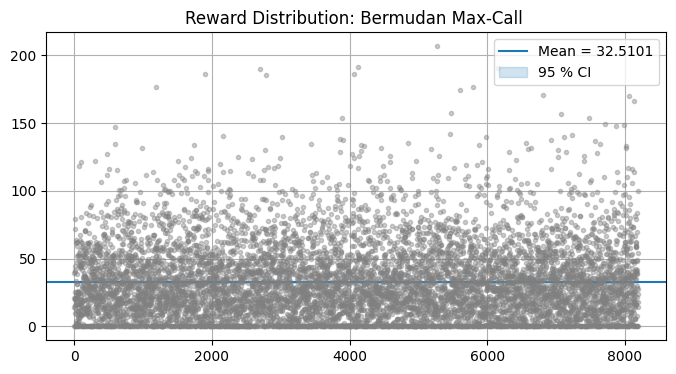

{'L_hat': 32.510117,
 'U_hat': 50.521088,
 'L_CI': (31.92188360412169, 33.098349550175186),
 'U_CI': (50.00567295750442, 51.03650233546433),
 'point_estimate': 41.515602111816406,
 'lr': 0.0001,
 'epochs': 35,
 'train_time_sec': 32.58}

In [13]:
bermudan = BermudanCall(T=3, K=100, sigma=0.2, delta=0.1, S0=110, r=0.05, N=9, M=8192, d=5)
replicate_paper_result("Bermudan Max-Call ", bermudan.g, bermudan.simulate, d=5, N=9)

In [14]:
''' 
# Local grid search around paper values
epoch_center = EPOCH_BASE + 5
best_params, best_val, df_grid = grid_search_lr_epochs(
    X_paths=bermudan.simulate(),
    g_fn=bermudan.g,
    N=9,
    d=5,
    lrs=[0.00005, 0.0001, 0.0002],
    epochs_list=[epoch_center - 200, epoch_center, epoch_center + 200]
)
display(df_grid.sort_values(by="mean_value", ascending=False))
'''

' \n# Local grid search around paper values\nepoch_center = EPOCH_BASE + 5\nbest_params, best_val, df_grid = grid_search_lr_epochs(\n    X_paths=bermudan.simulate(),\n    g_fn=bermudan.g,\n    N=9,\n    d=5,\n    lrs=[0.00005, 0.0001, 0.0002],\n    epochs_list=[epoch_center - 200, epoch_center, epoch_center + 200]\n)\ndisplay(df_grid.sort_values(by="mean_value", ascending=False))\n'

In [15]:
'''
#evaluate the best found parameters
replicate_paper_result("Tuned Bermudan Max-Call", bermudan.g, bermudan.simulate, d=5, N=9, lr=best_params[0], epochs=best_params[1])
'''

'\n#evaluate the best found parameters\nreplicate_paper_result("Tuned Bermudan Max-Call", bermudan.g, bermudan.simulate, d=5, N=9, lr=best_params[0], epochs=best_params[1])\n'

## Example 2: Callable Multi-Barrier Reverse Convertible

In [16]:
import numpy as np

class CallableMBRC:
    """
    Callable multi-barrier reverse convertible (BCJ-2020, Example 2).
    """

    def __init__(self, T, B, K, F, sigma, r, c, N, M, d):
        self.T, self.B, self.K, self.F, self.sigma = T, B, K, F, sigma
        self.r, self.c, self.N, self.M, self.d    = r, c, N, M, d
        self.dt = T / N
        self.discount = np.exp(-self.r * np.arange(N+1) * self.dt)

    # -------- #
    # Monte-Carlo simulation (Black–Scholes, independent assets)         #
    # -------- #
    def simulate(self):
        Z = np.random.randn(self.N, self.M, self.d).astype(np.float32)
        drift = (self.r - 0.5 * self.sigma**2) * self.dt
        logS  = np.cumsum(drift + self.sigma * np.sqrt(self.dt) * Z, axis=0)
        S     = 100 * np.exp(logS)
        S0    = 100 * np.ones((1, self.M, self.d), np.float32)
        return np.concatenate([S0, S], axis=0)              # (N+1,M,d)

    # -------- #
    # Payoff g(n,S)   — no external barrier_hit needed                   #
    # -------- #
    def g(self, n, S):
        """
        Parameters
        -
        n : scalar int or ndarray (M,)
        S : (N+1,M,d) cube  *or*  (M,d) slice

        Returns ndarray (M,)
        """
        # pick slice --
        if S.ndim == 3:
            if np.isscalar(n):
                S_n = S[int(n)]                             # (M,d)
            else:  # vector
                idx = np.asarray(n, int)
                S_n = S[idx, np.arange(S.shape[1])]         # (M,d)
        else:
            S_n = S                                         # already (M,d)

        # barrier breached up to n?  (approx. pathwise check)
        # – if full cube was passed, look back to time n
        if S.ndim == 3 and np.isscalar(n):
            breached = (S[:int(n)+1] < self.B).any(axis=(0,2))
        else:
            breached = (S_n < self.B).any(axis=1)

        n_arr = np.asarray(n, int)
        payoff = np.empty_like(n_arr, dtype=np.float32) if n_arr.ndim else None
        early  = n_arr < self.N

        # early call payoff -----
        if np.isscalar(n):
            if early:
                return self.c*n + self.discount[n]*self.F*np.ones(S_n.shape[0])
        else:
            payoff[early] = self.c*n_arr[early] + self.discount[n_arr[early]]*self.F

        # maturity payoff -------
        min_S  = S_n.min(axis=1)
        final  = np.where(breached | (min_S > self.K), self.F, min_S)
        if np.isscalar(n):
            return self.c*self.N + self.discount[self.N]*final
        else:
            payoff[~early] = self.c*self.N + self.discount[self.N]*final[~early]
            return payoff


In [17]:
def simulate_mbrc_paths_and_reward(mbrc):
    S_paths, barrier_hit = mbrc.simulate()
    return S_paths, lambda n, S: mbrc.g(n, S, barrier_hit)

In [18]:
def simulate_only():
    return mbrc.simulate()          # returns (N+1,M,d)


[REPLICATION PAPER] Callable MBRC (d=3)
Training with lr=0.0001, epochs=33 …
  n=11, converged at epoch 25
  n=10, converged at epoch 6
  n=9, converged at epoch 6
  n=7, converged at epoch 6
  n=6, converged at epoch 6
  n=5, converged at epoch 6
  n=2, converged at epoch 6
  n=1, converged at epoch 6
  n=0, converged at epoch 22
Training complete in 50.89 seconds.

 Estimated Lower Bound (L̂): 94.5576
   95% CI: [94.3502, 94.7651]

 Estimated Upper Bound (Û): 106.5503
   95% CI: [106.5450, 106.5556]

 Point Estimate (Midpoint): 100.5540


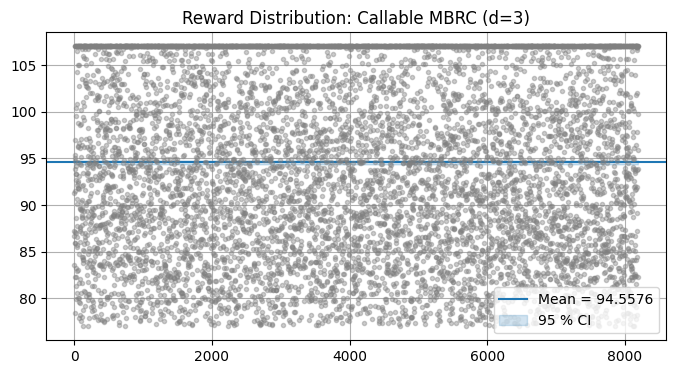

{'L_hat': 94.55765,
 'U_hat': 106.55034,
 'L_CI': (94.35021044823463, 94.76508496192162),
 'U_CI': (106.54504921267582, 106.55562827755855),
 'point_estimate': 100.55399322509766,
 'lr': 0.0001,
 'epochs': 33,
 'train_time_sec': 50.89}

In [19]:
mbrc = CallableMBRC(T=1, B=70, K=100, F=100, sigma=0.20, r=0.0, c=7/12,  N=12, M=8192, d=3)

# training & evaluation
replicate_paper_result("Callable MBRC (d=3)",  mbrc.g, simulate_only, d=3, N=12)


In [20]:
'''

# Values of d to test
d_values = [2, 5, 10, 15]  

# Local grid search for each d, reusing grid_search_lr_epochs
results = []
for d in d_values:
    print(f"\n Local Grid Search for d={d} ")
    
    # Run grid search for the current d value
    best_params, best_val, df_grid = grid_search_lr_epochs(
        X_paths=simulate_only(),
        g_fn=mbrc_g,
        N=12,
        d=d,
        lrs=[0.0001, 0.0003],  #Learning rates
        epochs_list=[EPOCH_BASE + d - 200, EPOCH_BASE + d, EPOCH_BASE + d + 200]
    )

    # Collect results
    for _, row in df_grid.iterrows():
        results.append({
            'd': d,
            'lr': row['lr'],
            'epochs': row['epochs'],
            'mean_value': row['mean_value']
        })
        
'''

'\n\n# Values of d to test\nd_values = [2, 5, 10, 15]  \n\n# Local grid search for each d, reusing grid_search_lr_epochs\nresults = []\nfor d in d_values:\n    print(f"\n Local Grid Search for d={d} ")\n    \n    # Run grid search for the current d value\n    best_params, best_val, df_grid = grid_search_lr_epochs(\n        X_paths=simulate_only(),\n        g_fn=mbrc_g,\n        N=12,\n        d=d,\n        lrs=[0.0001, 0.0003],  #Learning rates\n        epochs_list=[EPOCH_BASE + d - 200, EPOCH_BASE + d, EPOCH_BASE + d + 200]\n    )\n\n    # Collect results\n    for _, row in df_grid.iterrows():\n        results.append({\n            \'d\': d,\n            \'lr\': row[\'lr\'],\n            \'epochs\': row[\'epochs\'],\n            \'mean_value\': row[\'mean_value\']\n        })\n        \n'

In [21]:
''' 
# Display results for grid search
df_results = pd.DataFrame(results)
display(df_results.sort_values(by="mean_value", ascending=False))
'''

' \n# Display results for grid search\ndf_results = pd.DataFrame(results)\ndisplay(df_results.sort_values(by="mean_value", ascending=False))\n'

## Example 3: Fractional Brownian Motion

In [22]:
class FBM:
    def __init__(self, H, N=100, M=8192, d=None):
        self.H, self.N, self.M = H, N, M
        self.d = d if d is not None else N
        self.dt = 1.0 / N
        self.time_grid = np.linspace(0, 1, N + 1)
        self.paths  = self._simulate_paths()          # (M, N+1)
        self.states = self._build_markov_embedding()  # (M, N+1, d)

    # ----- internal helpers --------
    def _covariance_matrix(self):
        t, H = self.time_grid, self.H
        return 0.5 * (np.abs(t[:, None])**(2*H)
                      + np.abs(t[None, :])**(2*H)
                      - np.abs(t[:, None]-t[None, :])**(2*H))

    def _simulate_paths(self):
        L = np.linalg.cholesky(self._covariance_matrix()
                               + 1e-10*np.eye(self.N+1))
        Z = np.random.randn(self.N+1, self.M)
        return (L @ Z).T                       # (M,N+1)

    def _build_markov_embedding(self):
        out = np.zeros((self.M, self.N+1, self.d), dtype=np.float32)
        for n in range(self.N+1):
            hist = self.paths[:, max(0, n-self.d+1):n+1][:, ::-1]
            out[:, n, :hist.shape[1]] = hist
        return out

    # ----- user-facing getters ----
    def simulate(self):
        """return (N+1, M, d) cube for training/eval"""
        # swap to (N+1,M,d) so time is first axis like other examples
        return np.transpose(self.states, (1, 0, 2)).astype(np.float32)

    def reward_fn(self):
        """g(n,X) = X[n,:,0] for cube or X[:,0] for slice."""
        def g(n, X):
            if X.ndim == 3:                    # full cube
                if np.isscalar(n):
                    return X[int(n), :, 0]
                idx = np.asarray(n, int)
                return X[idx, np.arange(idx.size), 0]
            else:                              # already slice (M,d)
                return X[:, 0]
        return g



[REPLICATION PAPER] Fractional Brownian Motion (H=0.3)
Training with lr=0.0001, epochs=35 …
  n=99, converged at epoch 6
  n=98, converged at epoch 6
  n=97, converged at epoch 6
  n=96, converged at epoch 6
  n=95, converged at epoch 6
  n=94, converged at epoch 6
  n=93, converged at epoch 6
  n=92, converged at epoch 6
  n=91, converged at epoch 6
  n=90, converged at epoch 6
  n=89, converged at epoch 6
  n=88, converged at epoch 6
  n=87, converged at epoch 6
  n=86, converged at epoch 1
  n=85, converged at epoch 6
  n=84, converged at epoch 6
  n=83, converged at epoch 6
  n=82, converged at epoch 6
  n=81, converged at epoch 6
  n=80, converged at epoch 6
  n=79, converged at epoch 6
  n=78, converged at epoch 6
  n=77, converged at epoch 6
  n=76, converged at epoch 6
  n=75, converged at epoch 6
  n=74, converged at epoch 6
  n=73, converged at epoch 6
  n=72, converged at epoch 6
  n=71, converged at epoch 6
  n=70, converged at epoch 6
  n=69, converged at epoch 6
  n=68, 

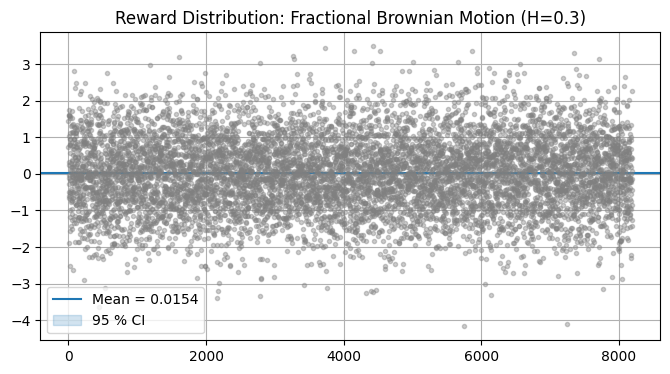

{'L_hat': 0.015408793,
 'U_hat': nan,
 'L_CI': (-0.00620671579621767, 0.0370243027248237),
 'U_CI': (nan, nan),
 'point_estimate': nan,
 'lr': 0.0001,
 'epochs': 35,
 'train_time_sec': 165.89}

In [23]:
# instantiate fBM with paper grid
fbm = FBM(H=0.3, N=100, M=8192, d=100)

# g_fn and simulator expected by replicate_paper_result
g_fn  = fbm.reward_fn()
simulate_fbm = fbm.simulate          # returns (N+1,M,d)  with N=100

# run replication exactly as for other examples
replicate_paper_result("Fractional Brownian Motion (H=0.3)", g_fn, simulate_fbm, d=5, N=100)           # must equal fbm.N


## TEST NOT FUNCTIONING

In [24]:
'''  
def local_grid_search_for_fbm(name, d_values, H_values, N, lr_values=[0.0001, 0.0003], epoch_offset=200):
    """
    Run grid search for fBM problem using FBM class for multiple (H, d) settings.
    """
    results = []

    for H in H_values:
        for d in d_values:
            print(f"\n--- Local Grid Search for H={H}, d={d} ---")

            # Generate fBM data
            fbm = FBM(H=H, N=N, M=8192, d=d)
            X_fbm_padded = fbm.get_state_vectors()
            g_fn = fbm.reward_fn()

            # Choose center epoch based on d (same heuristic as in your notebook)
            epoch_center = EPOCH_BASE + d
            best_params, best_val, df_grid = grid_search_lr_epochs(
                X_paths=X_fbm_padded,
                g_fn=g_fn,
                N=N,
                d=d,
                lrs=lr_values,
                epochs_list=[
                    epoch_center - epoch_offset,
                    epoch_center,
                    epoch_center + epoch_offset
                ]
            )

            for _, row in df_grid.iterrows():
                results.append({
                    'H': H,
                    'd': d,
                    'lr': row['lr'],
                    'epochs': row['epochs'],
                    'mean_value': row['mean_value']
                })

    df_results = pd.DataFrame(results)
    display(df_results.sort_values(by="mean_value", ascending=False))
    return df_results

'''

'  \ndef local_grid_search_for_fbm(name, d_values, H_values, N, lr_values=[0.0001, 0.0003], epoch_offset=200):\n    """\n    Run grid search for fBM problem using FBM class for multiple (H, d) settings.\n    """\n    results = []\n\n    for H in H_values:\n        for d in d_values:\n            print(f"\n--- Local Grid Search for H={H}, d={d} ---")\n\n            # Generate fBM data\n            fbm = FBM(H=H, N=N, M=8192, d=d)\n            X_fbm_padded = fbm.get_state_vectors()\n            g_fn = fbm.reward_fn()\n\n            # Choose center epoch based on d (same heuristic as in your notebook)\n            epoch_center = EPOCH_BASE + d\n            best_params, best_val, df_grid = grid_search_lr_epochs(\n                X_paths=X_fbm_padded,\n                g_fn=g_fn,\n                N=N,\n                d=d,\n                lrs=lr_values,\n                epochs_list=[\n                    epoch_center - epoch_offset,\n                    epoch_center,\n                    ep

In [25]:
'''
#  Run Fractional Brownian Motion  
# H and d values to loop over
H_values = [0.1, 0.3, 0.5, 0.7]
d_values = [2, 5, 10, 15]

# Example fBM object and reward function
fbm = FBM(H=0.3, N=100, M=8192, d=100)
'''

'\n#  Run Fractional Brownian Motion  \n# H and d values to loop over\nH_values = [0.1, 0.3, 0.5, 0.7]\nd_values = [2, 5, 10, 15]\n\n# Example fBM object and reward function\nfbm = FBM(H=0.3, N=100, M=8192, d=100)\n'

In [26]:
'''
# Get padded state paths (shape: M, N+1, d)
X_fbm_padded = fbm.get_state_vectors()

# Get reward function g(n, X) = X[n, :, 0]
fbm_g = fbm.reward_fn()

# Define a wrapper to match replicate_paper_result signature
def simulate_fbm_wrapper():
    return X_fbm_padded
'''

'\n# Get padded state paths (shape: M, N+1, d)\nX_fbm_padded = fbm.get_state_vectors()\n\n# Get reward function g(n, X) = X[n, :, 0]\nfbm_g = fbm.reward_fn()\n\n# Define a wrapper to match replicate_paper_result signature\ndef simulate_fbm_wrapper():\n    return X_fbm_padded\n'

In [27]:
'''
# Now call the result replication function
replicate_paper_result("Fractional Brownian Motion (H=0.3)",fbm.reward_fn(), simulate_fbm_wrapper, d=5, N=100)  
'''

'\n# Now call the result replication function\nreplicate_paper_result("Fractional Brownian Motion (H=0.3)",fbm.reward_fn(), simulate_fbm_wrapper, d=5, N=100)  \n'